#### IMPORTING LIBRARYS


In [1]:
import time 
start=time.time()
import pandas as pd 
import numpy as np 
import seaborn as sns 
from nltk  import FreqDist
from random import randint
from nltk.corpus import stopwords
import matplotlib.pyplot as plt  
from wordcloud import STOPWORDS,WordCloud  
from matplotlib import rcParams
from nltk.tokenize import sent_tokenize, word_tokenize 

#### LOADING AND PREPARING DATA

In [2]:

df_train=pd.read_csv("./data/train.csv") 
df_essays=pd.DataFrame(df_train["full_text"])
df_test=pd.read_csv("./data/test.csv")   
X=df_essays 
y=df_train.drop(["text_id","full_text"],axis=1)  
essays=df_essays["full_text"]
essays=list(essays) 
essays=" ".join(essays)  
essays=('''"""''') +essays + ('''"""''')  
df_train

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5
...,...,...,...,...,...,...,...,...
3906,FFD29828A873,I believe using cellphones in class for educat...,2.5,3.0,3.0,3.5,2.5,2.5
3907,FFD9A83B0849,"Working alone, students do not have to argue w...",4.0,4.0,4.0,4.0,3.5,3.0
3908,FFDC4011AC9C,"""A problem is a chance for you to do your best...",2.5,3.0,3.0,3.0,3.5,3.0
3909,FFE16D704B16,Many people disagree with Albert Schweitzer's ...,4.0,4.5,4.5,4.0,4.5,4.5


## GLOBAL FUNCTIONS

In [3]:
stop_words=stopwords.words("english")  
def remove_unwanted(string,unwanted):  
    for i in unwanted: 
        string=string.replace(i,"")
    return string    
def filter_text(string,stop_words=stop_words,unique_words=True,filter_by_sw=True): 
    string=remove_unwanted(string,["'",'"',".",","])
    tokenized=word_tokenize(string) 
    filtered=tuple(tokenized)
    if filter_by_sw:
        filtered=tuple([word.casefold() for word in tokenized if word.casefold() not in stop_words])
    if unique_words:
        filtered =tuple(set(filtered))
    return filtered 
def get_num_words(string,unique_words=True,filter_by_sw=True):  
    filtered=filter_text(string,unique_words=unique_words,filter_by_sw=filter_by_sw)
    return len(filtered)
def makeWordcloud(text,stopwords=STOPWORDS,maxwords=300,width=800,height=800,color="black",column="fulltext"): 
    if isinstance(text,pd.core.frame.DataFrame):  
        newtext="\n".join(text[column])
        wordcloud= WordCloud(width=width,height=height,stopwords=stopwords,background_color=color,max_words=maxwords).generate(text) 
        plt.figure(figsize=(20,15))  
        plt.clf()
        plt.imshow(wordcloud)
        plt.axis("off")  
        return plt.show()  
    elif isinstance(text,str):  
        wordcloud= WordCloud(width=width,height=height,stopwords=stopwords,background_color=color,max_words=maxwords).generate(text) 
        plt.figure(figsize=(20,15))  
        plt.clf()
        plt.imshow(wordcloud)
        plt.axis("off")  
        return plt.show()
    elif isinstance(text,list) or isinstance(text,np.ndarray) or isinstance(text,pd.core.series.Series): 
        newtext=" ".join(text)
        wordcloud= WordCloud(width=width,height=height,stopwords=stopwords,background_color=color,max_words=maxwords).generate(text) 
        plt.figure(figsize=(20,15))  
        plt.clf()
        plt.imshow(wordcloud)
        plt.axis("off")  
        return plt.show()  
def create_txt_with_example(specific=randint(0,len(df_train["full_text"]))): 
    newExample=open("./examples/example_%d.txt" % specific,"w") 
    newExample.write(df_train["full_text"][specific]) 
    newExample.close()  
def getcommonwords(text,amount=10):  
    filtered=filter_text(text,unique_words=False) 
    freq=FreqDist(filtered) 
    return tuple([word[0] for word in freq.most_common(amount)])
    

In [4]:
df_relevant=df_train  

## CREATE AN EXAMPLE txt

In [5]:
#create_txt_with_example()

## ADDING RELEVANT INFORMATION

### ADDING NUMBER OF WORDS PER ESSAY

In [6]:
df_train["full_text"]
e_string=df_essays["full_text"][300]
df_relevant["n_of_words"]=[get_num_words(essay,unique_words=False) for essay in df_train["full_text"]] 
df_relevant

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,n_of_words
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0,131
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5,217
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5,141
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0,303
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5,112
...,...,...,...,...,...,...,...,...,...
3906,FFD29828A873,I believe using cellphones in class for educat...,2.5,3.0,3.0,3.5,2.5,2.5,96
3907,FFD9A83B0849,"Working alone, students do not have to argue w...",4.0,4.0,4.0,4.0,3.5,3.0,217
3908,FFDC4011AC9C,"""A problem is a chance for you to do your best...",2.5,3.0,3.0,3.0,3.5,3.0,112
3909,FFE16D704B16,Many people disagree with Albert Schweitzer's ...,4.0,4.5,4.5,4.0,4.5,4.5,239


### ADDING 10 MOST COMMON WORDS OF EACH ESSAY

In [7]:
df_relevant["most_common_words"]=[getcommonwords(essay,10) for essay in df_essays["full_text"]]  
df_relevant

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,n_of_words,most_common_words
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0,131,"(students, go, u, wont, get, classes, home, sc..."
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5,217,"(change, different, see, understand, need, thi..."
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5,141,"(average, sports, school, activities, policy, ..."
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0,303,"(make, choices, dont, others, want, people, be..."
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5,112,"(people, act, change, kindess, person, nice, i..."
...,...,...,...,...,...,...,...,...,...,...
3906,FFD29828A873,I believe using cellphones in class for educat...,2.5,3.0,3.0,3.5,2.5,2.5,96,"(believe, could, using, cellphones, use, us, s..."
3907,FFD9A83B0849,"Working alone, students do not have to argue w...",4.0,4.0,4.0,4.0,3.5,3.0,217,"(students, work, group, working, get, student,..."
3908,FFDC4011AC9C,"""A problem is a chance for you to do your best...",2.5,3.0,3.0,3.0,3.5,3.0,112,"(problem, best, every, get, chance, quote, don..."
3909,FFE16D704B16,Many people disagree with Albert Schweitzer's ...,4.0,4.5,4.5,4.0,4.5,4.5,239,"(others, people, example, influence, matter, s..."


## VISUALIZING DATA 

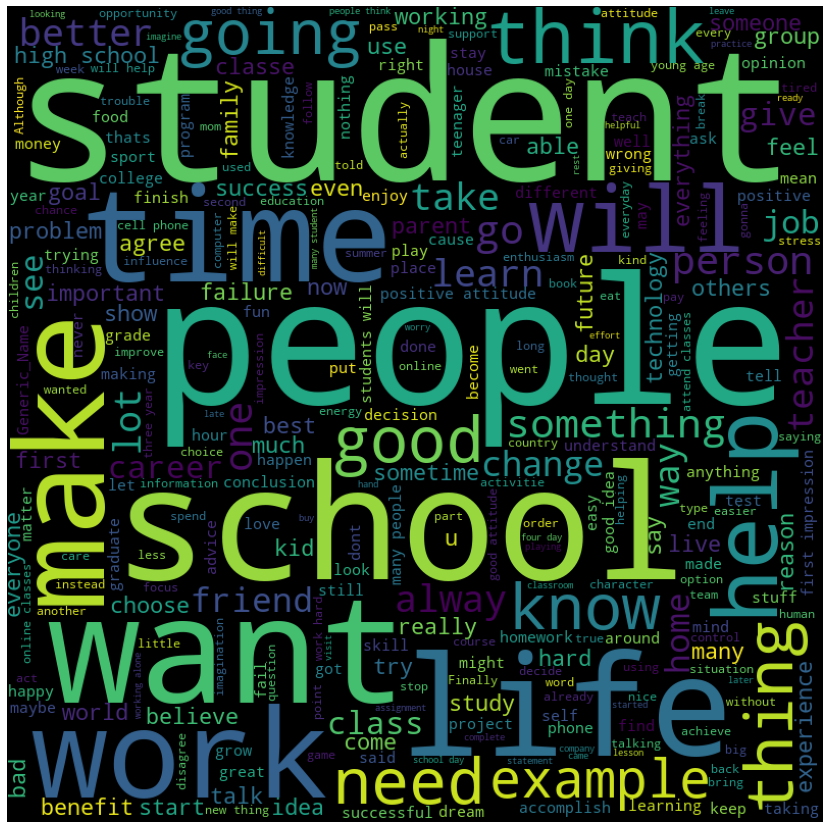

In [8]:
makeWordcloud(essays) 

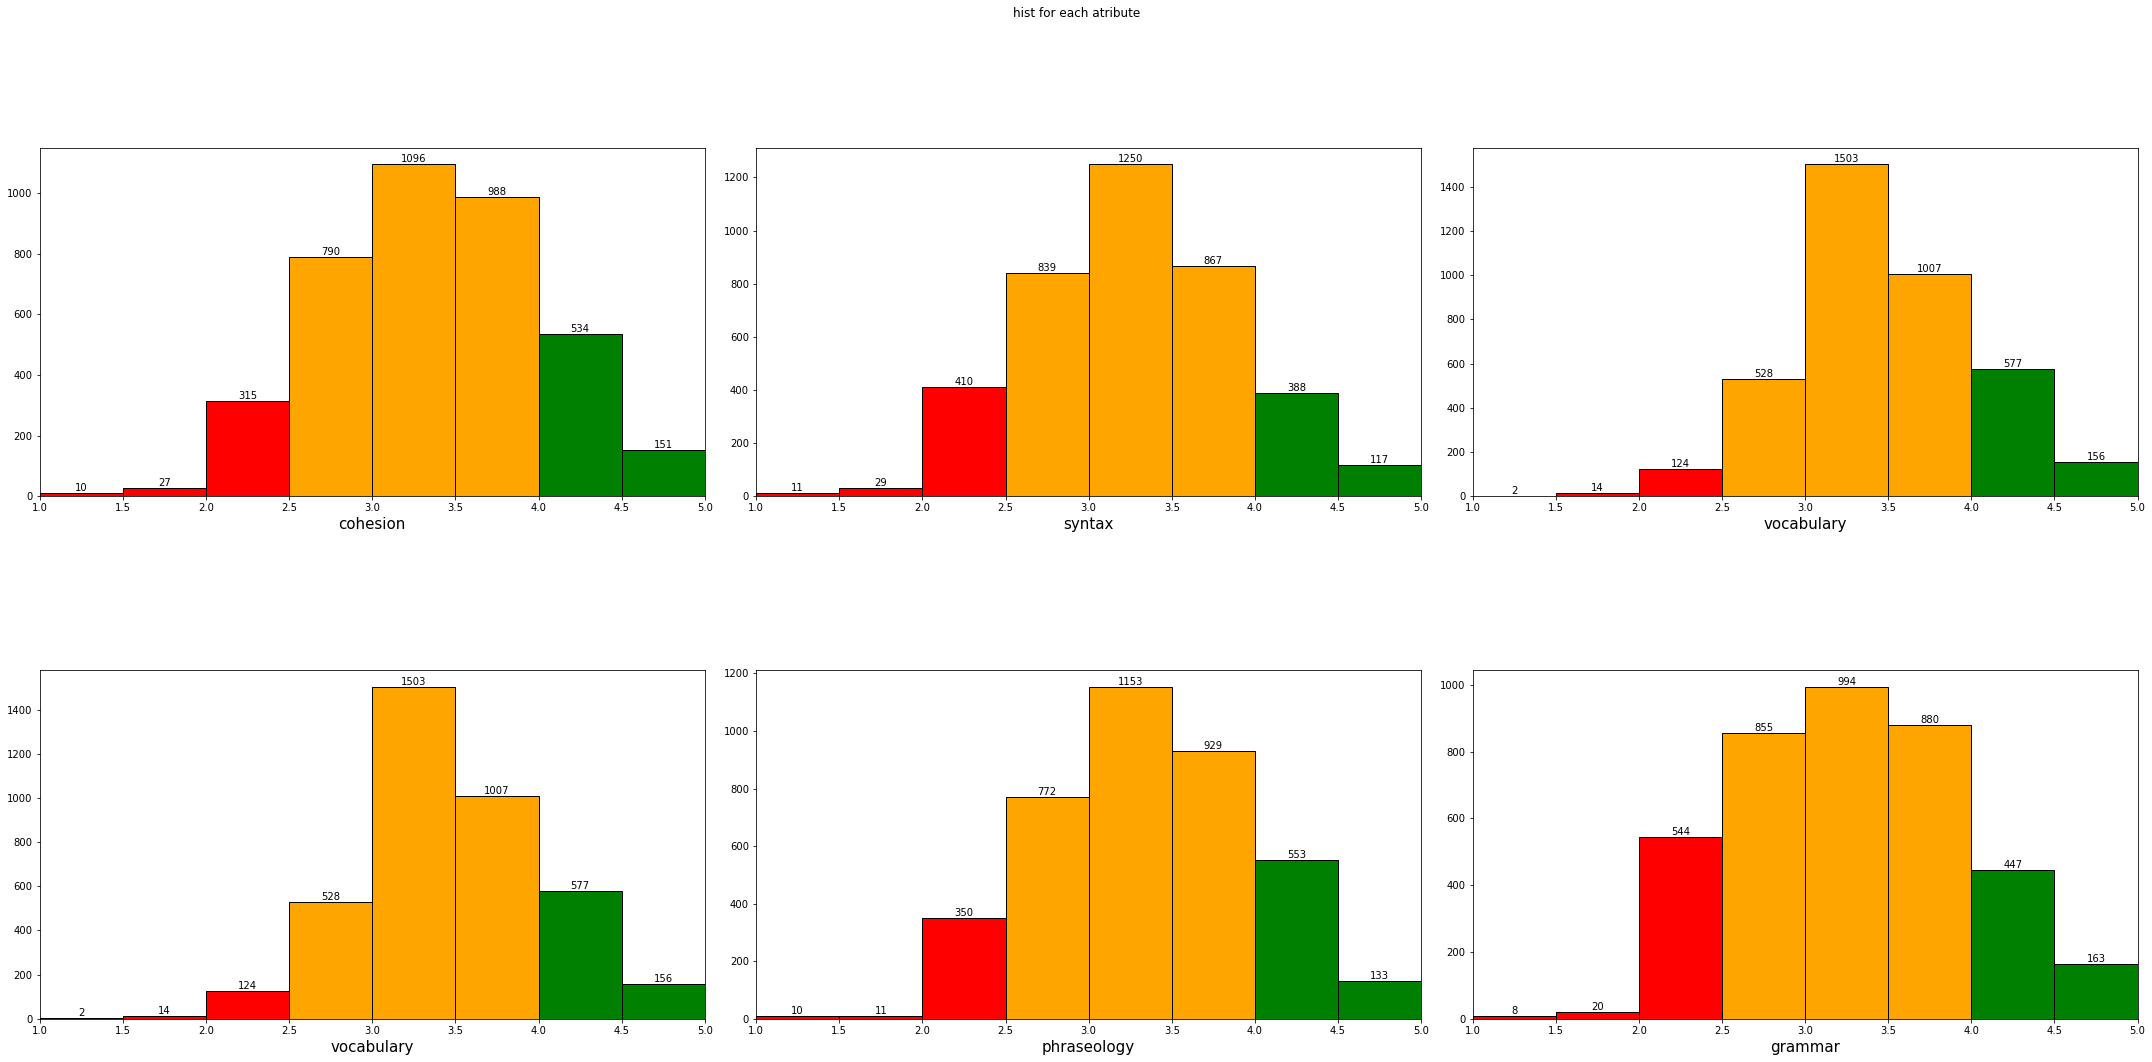

In [9]:

fig,ax =plt.subplots(2,3) 
fig.suptitle("hist for each atribute")   
fig.set_figwidth(30)
fig.set_figheight(15)
dimX=ax.shape[0] 
dimY=ax.shape[1]    
target_names=list(y)
for i in range(dimX): 
    for j in range(dimY) : 
        oneDIndex=(i*dimX)+j
        N, bins, patches=ax[i,j].hist(y[target_names[oneDIndex]],edgecolor="black",bins=8)   
        for k in range(0,3):
            patches[k].set_facecolor("red") 
        for k in range(3,6): 
            patches[k].set_facecolor("orange")
        for k in range(6,len(patches)):  
            patches[k].set_facecolor("green")
        ax[i,j].bar_label(patches)
        ax[i,j].set_xlabel(target_names[oneDIndex],size=15)  
        ax[i,j].set_xbound(lower=1.0,upper=5.0)
fig.align_labels() 
fig.tight_layout()
fig.subplots_adjust(top=0.85,hspace=0.5)  

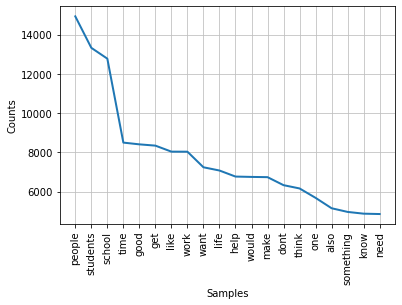

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [10]:
filtered_words=filter_text(essays,unique_words=False) 
common=FreqDist(filtered_words)
common.plot(20)

## Running time

In [11]:
end=time.time() 
print(end-start)

23.578076124191284
